# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [2]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cls
0,202388889,1.0
1,1392518336,0.0
2,361208576,1.0
3,1535215357,1.0
4,4396196375,1.0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

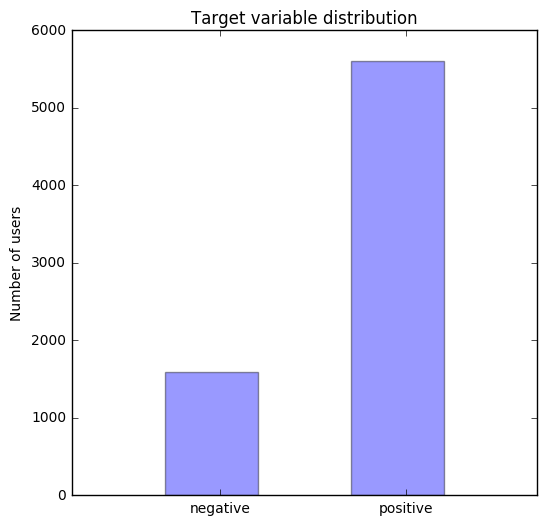

In [3]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cls"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [4]:
CONSUMER_KEY = ""
CONSUMER_SECRET = ""

ACCESS_TOKEN_KEY = ""
ACCESS_TOKEN_SECRET = ""

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничено 30тыс в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [5]:
location_cache = dict()

In [6]:
GEO_USER_NAME = ""

def get_coordinates_by_location(location):    
    """
    This function gets geographic coordinates and city name
    form external web service GeoNames using 'location' string.
    """
    
    inval = (float('nan'), float('nan'), "INVAL")
    
    service = 'http://api.geonames.org/searchJSON'
    print location
    
    if location not in location_cache.keys():
        arr = location.split(',')
        
        """if len(arr) == 2:
            try:
                print 'Trying to map float' 
                coords = tuple(map(float, arr))
                print coords
                location_cache[location] = coords
                print 'Success'
                return (coords[0], coords[1], location)
            except:
                print 'Exception'
                ;"""
        
        ps = {'q': location, 'maxRows': 10, 'username': GEO_USER_NAME}
        target_city = arr[0]
        if target_city == location:
            location_cache[location] = inval
            return inval
        
        r = requests.get(service, params=ps)
        if r.status_code == requests.codes.ok:
            found = False
            #print 'Request passed'
            try:
                js = r.json()
                if js is None or js['geonames'] is None or len(js['geonames']) == 0:
                    location_cache[location] = inval
                    return inval
                for entry in js['geonames']:
                    #print entry
                    if entry['toponymName'] == target_city:
                        #print 'Location found'
                        coords = (float(entry['lat']), float(entry['lng']), entry['countryName'])
                        location_cache[location] = coords
                        return coords

                #Location not found
                location_cache[location] = inval
                return inval
            except:
                #print 'Bad request result'
                return inval
        else:
            #print 'Tough luck'
            return inval
    else:
        return location_cache[location]

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [7]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'tmp_user_records'
processed_users = set()
if os.path.exists(tmp_file_name):
    with open(tmp_file_name, 'r') as f:
        for line in f:
            try:
                user = json.loads(line)
                if user['uid'] not in processed_users:
                    user_records.append(user)
                    processed_users.add(user['uid'])
                #print 'Lucky'
            except:
                #print 'No luck'
                ;
    
f = open(tmp_file_name + "_dump", 'a')
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record

In [8]:
def get_user_records(df):
    # some_downloaded_user = get_user_from_api
    # also write user as json line in temporary file
    # return [twitter_user_to_dataframe_record(some_downloaded_user)]
    
    def routine(user, result):
        try:
            to_add = twitter_user_to_dataframe_record(user)
            result.append(to_add)
            processed_users.add(user.id)

            f.write(json.dumps(to_add))
            f.write('\n')
        except:
            ;

        return
    
    uid_list = df['uid'].tolist()
    result = []
    users = []
    batch_size = 100
    
    iter_times = len(uid_list) / batch_size
    for i in range(iter_times):
        sliced = uid_list[i * batch_size : (i + 1) * batch_size]
        #print sliced
        
        users = api.UsersLookup(sliced)
        for user in users:
            #print user.id
            if user.id not in processed_users: 
                routine(user, result)
            else:
                for user_r in user_records:
                    if user_r['uid'] == user.id:
                        result.append(user_r)
                        break

    return result

In [10]:
len(user_records)

7136

In [42]:
# Maximum number of user IDs returned by Twitter's user lookup

user_records = get_user_records(df_users)

In [43]:
len(user_records)

11355

In [13]:
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

Creating data frame from loaded data
Merging data frame with the training set
Finished building data frame


## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://stroykova.github.io/sphera/l1_1.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (1 балл).

In [14]:
grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))

In [15]:
grouped.head()

,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1.0,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",27.74836,-82.70343,United States,2010-10,1052.0,1961.0,9481.0,21320.0,27.0
1,1392518336,0.0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,1.5486,103.5269,Malaysia,2013-04,1194.0,836.0,19287.0,7182.0,110.0
2,361208576,1.0,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",53.48095,-2.23743,United Kingdom,2011-08,633.0,576.0,7851.0,1141.0,28.0
3,1535215357,1.0,L,laurynjiles,I'd rather be in Paris.,False,Marvel. DC.,0,0,Unknown,2013-06,2370.0,2437.0,187994.0,88031.0,68.0
4,4396196375,1.0,#1stEdifyToUplift,EdifyToUplift,Awareness.Advocacy.Ascend🎈• Building awarenes...,False,God is my refuge; gem❤️,0,0,Unknown,2015-12,1251.0,966.0,36655.0,26844.0,74.0
5,17938477,1.0,Skelly & Mulder,SkellyScribbles,"visual artist, writer, and photographer.",False,"Richmond, VA",37.55376,-77.46026,United States,2008-12,332.0,500.0,5474.0,8040.0,56.0
6,720288026681716737,1.0,Zane Savage,SiNGLEGADGET,"Current gadgets, tech news and reviews, in a s...",False,"Toronto, Ontario",43.70011,-79.4163,Canada,2016-04,67.0,70.0,9455.0,37.0,87.0
7,174004739,1.0,marc,_MightyMarc_,NaN,False,NaN,NaN,NaN,NaN,2010-08,371.0,1880.0,56379.0,132880.0,27.0
8,53783678,1.0,Lady Attis ⚦,ladyattis,Your friendly neighborhood androgynous android...,False,"Minneapolis, MN",44.97997,-93.26384,United States,2009-07,760.0,1078.0,39318.0,69560.0,52.0
9,257662370,1.0,Nick Watches Marvel!,NickWatchesMCU,Excelsior #TrueBelievers❗️#MCU‼️ #LukeCage 9/3...,False,"Seattle, WA",47.60621,-122.33207,United States,2011-02,766.0,1376.0,19235.0,9408.0,29.0


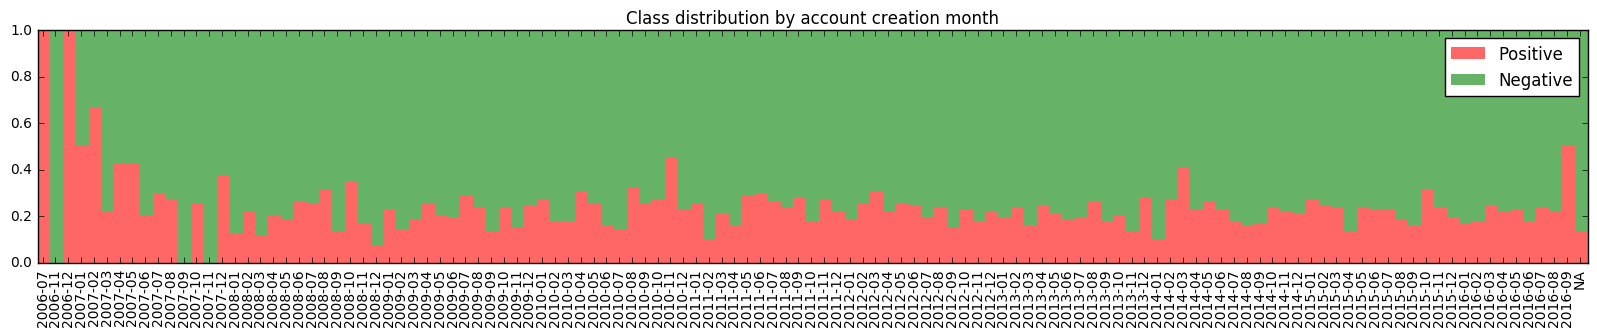

In [16]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = []
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    
    dts = list(set(grouped.size().keys().tolist()))
    dct = grouped['cls'].value_counts().to_dict()
    
    for key in dct.keys():
        i = dts.index(key[0])
        if key[1] == 1:
            count_neg[i] = dct[key]
        else:
            count_pos[i] = dct[key]
    
    return count_pos, count_neg, dts

count_pos, count_neg, dts = count_users(grouped)
  
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://stroykova.github.io/sphera/l1_2.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

In [17]:
def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """
    matrix = df_full.as_matrix()
    const = 2
    painted = dict.fromkeys([0.0, 1.0], set())
    for i in range(len(matrix)):
        cls = matrix[i][1]
        if cls == 0:
            color = 'ro'
        else:
            color = 'go'
        lat = float(matrix[i][7])
        lng = float(matrix[i][8])
        #print type(lat), type(lng)
        country = matrix[i][9]
        
        if country != unicode('INVAL'):
            if not (math.isnan(lat) or math.isnan(lng)):
                try:
                    if (lat, lng) not in painted[cls]:
                        m.plot(const*(int(lng)/const), const*(int(lat)/const), color, latlon=True, alpha=0.6)
                except:
                    #print "What is this I don't even..."
                    ;
                    
    return

In [18]:
float('nan')

nan

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


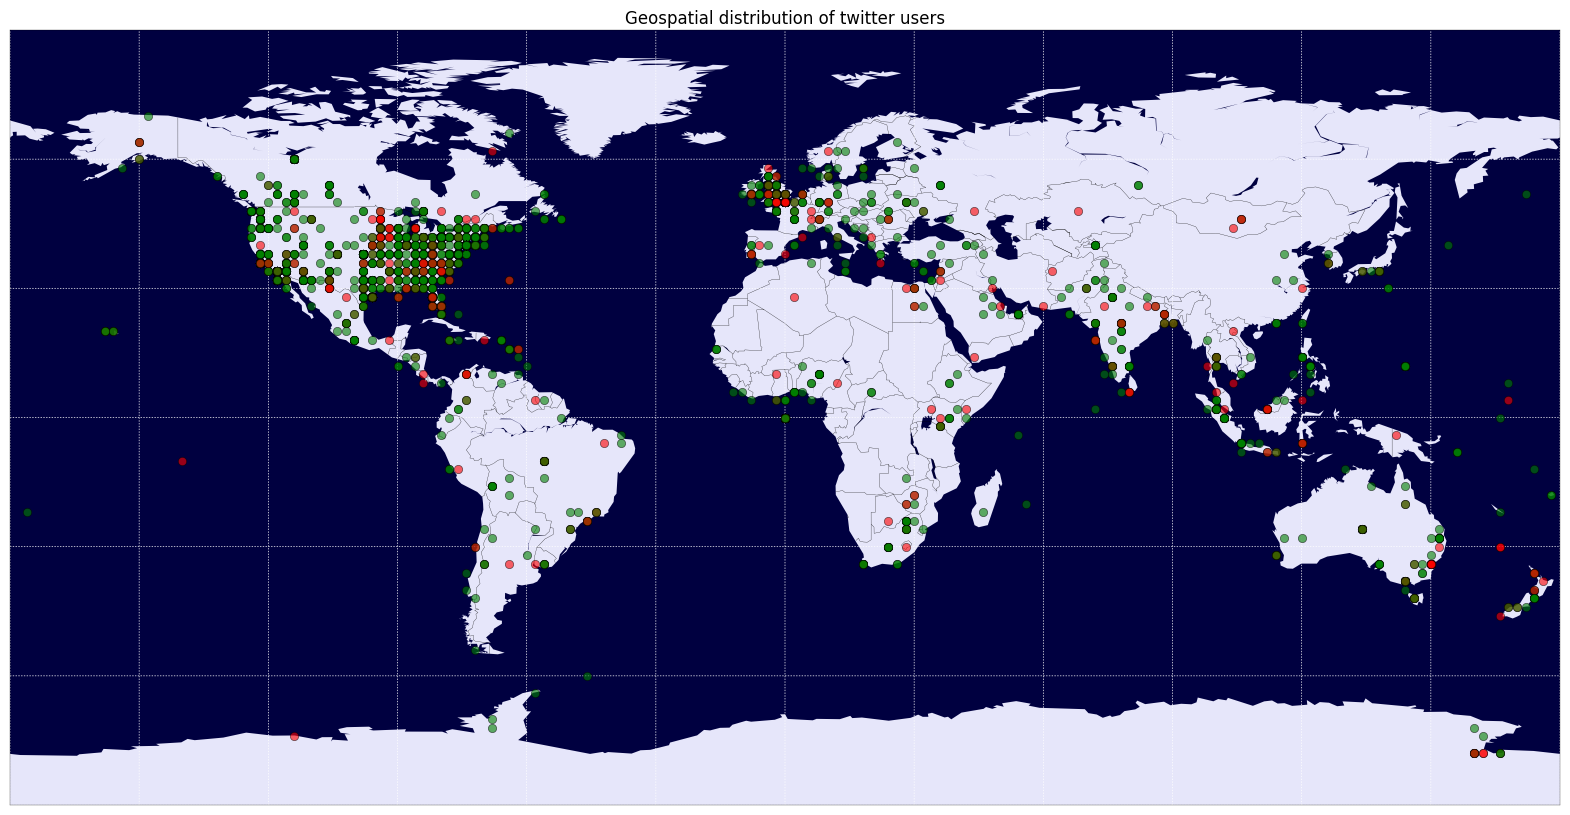

In [19]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).


В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* Точки одного класса ставятся в одно место только один раз
* Задан коэффициент прозрачности точек.
    * Таким образом видно наличие точек разных классов в одном месте
* Производится округление координат

#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
    1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
    2. Постройте гистограммы для пользователей двух классов.
[подсказка](http://stroykova.github.io/sphera/l1_3.png) 
    3. На основе полученных данных ответьте на вопросы 
        1. Почему mean и median имеют разные значения?
        2. Пользователи какого класса популярнее? Аргументируйте ответ.
Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. (1 балл)

### Ответы на вопросы
3.1 mean и meadian имеют разные значения, так как в их определениях заложен разный смысл: mean - среднее арифметическое, а медиан - 50-квантиль (слева и справа число значений одинакого)

3.2 примерно в 8 случаях из 10 получается, что пользователи класса 0.0 популярнее пользователей класса 1.0. Данное умозаключение получено путем сравнения значения mean на гистограммах. Также за классом 0.0 были замечены максимальные значения количества подписчиков.

In [20]:
def descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class):
    #Calculate min max and median. Plot histogram
    pl.figure(figsize(20,12))
    step = 0.5
    keys = []
    for i in range(4):
        keys.append(i * 0.5)
    
    def get_data(users):
        return [users['followers_count'].min(), \
                users['followers_count'].max(), \
                users['followers_count'].mean(), \
                users['followers_count'].median()]
    
    p1 = pl.bar(keys, get_data(users_wth_neg_class), step, color='green', alpha=0.5)
    p2 = pl.bar(keys, get_data(users_wth_pos_class), step, color='red', alpha=0.5)
    
    pl.legend((p1[0], p2[0]), ('Negative', 'Positive'))
    pl.show()
    return

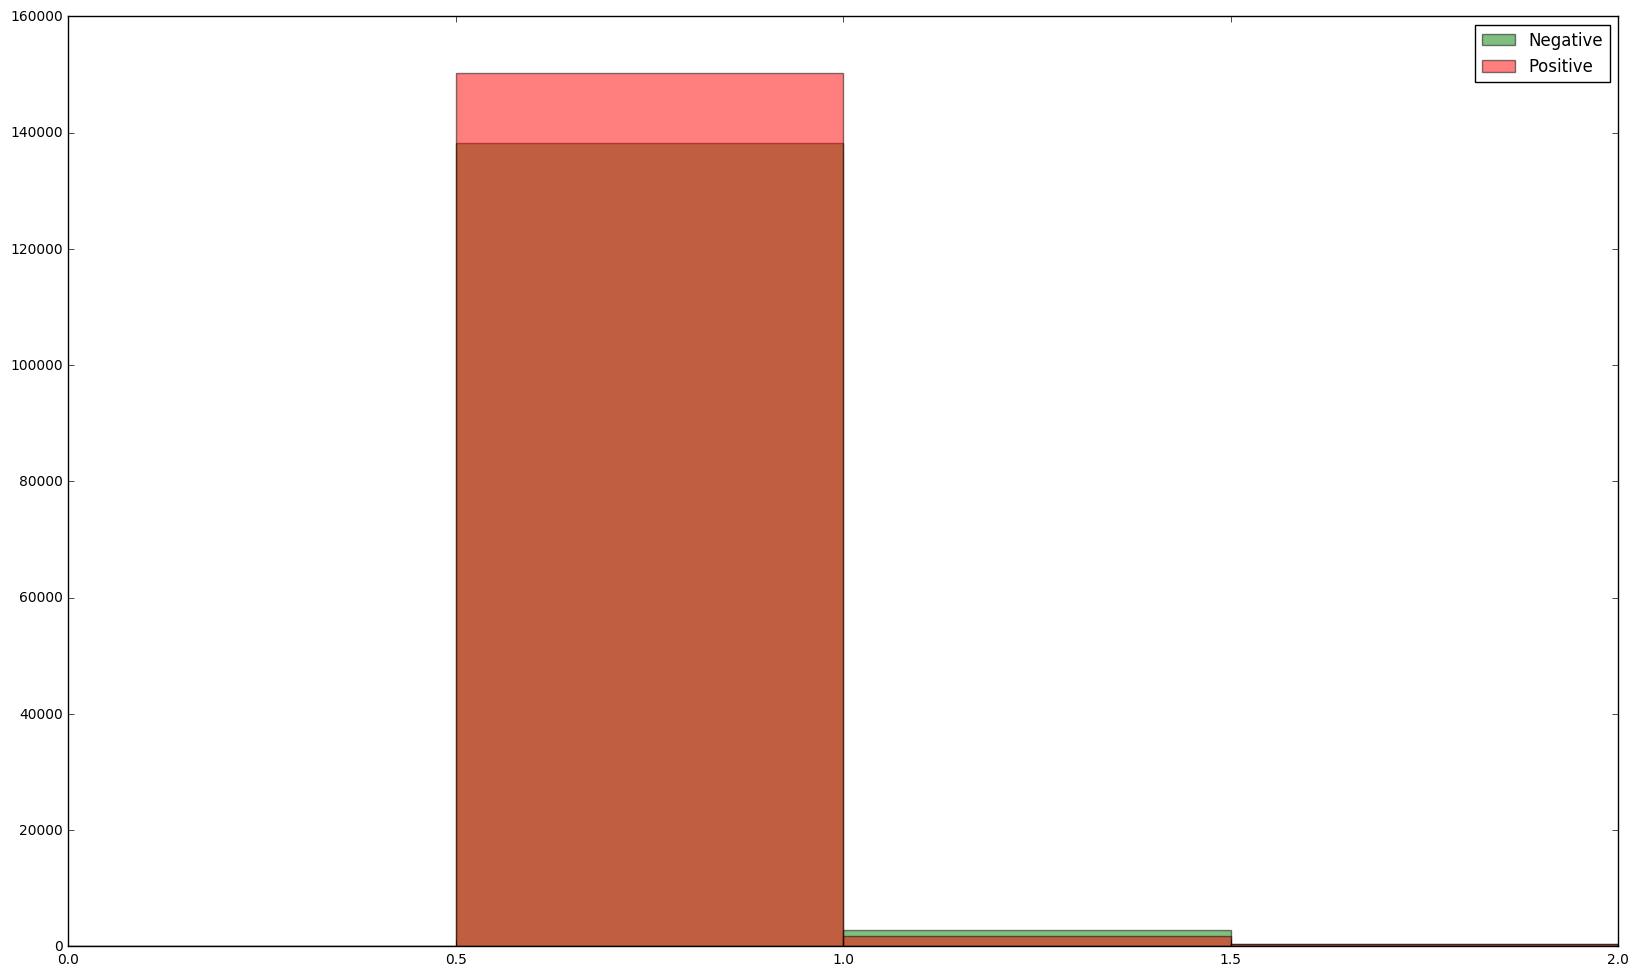

In [39]:
sample_number = 500
users_wth_neg_class = df_full[df_full["cls"]==0].sample(sample_number)
users_wth_pos_class = df_full[df_full["cls"]==1].sample(sample_number)

descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class)


Смотрим на полученный data frame и сохраняем его в .csv файл.

In [40]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1.0,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",27.74836,-82.70343,United States,2010-10,1052.0,1961.0,9481.0,21320.0,27.0
1,1392518336,0.0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,1.5486,103.5269,Malaysia,2013-04,1194.0,836.0,19287.0,7182.0,110.0
2,361208576,1.0,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",53.48095,-2.23743,United Kingdom,2011-08,633.0,576.0,7851.0,1141.0,28.0
3,1535215357,1.0,L,laurynjiles,I'd rather be in Paris.,False,Marvel. DC.,0,0,Unknown,2013-06,2370.0,2437.0,187994.0,88031.0,68.0
4,4396196375,1.0,#1stEdifyToUplift,EdifyToUplift,Awareness.Advocacy.Ascend🎈• Building awarenes...,False,God is my refuge; gem❤️,0,0,Unknown,2015-12,1251.0,966.0,36655.0,26844.0,74.0
